# **_Texture Segmentations_**

<br>

### __*Import Libraries*__

In [1]:
import numpy as np, matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# from skimage.color import label2rgb
from skimage.filters.rank import entropy
from skimage import io, morphology   # , color, filters
from skimage.feature import graycomatrix, graycoprops
# from skimage.segmentation import find_boundaries, mark_boundaries

TM_PATH = 'textury_train/tm1_1_1.png'
GT_PATH = 'textury_train/gt1_1.png'

<br>

### __*Load Data*__

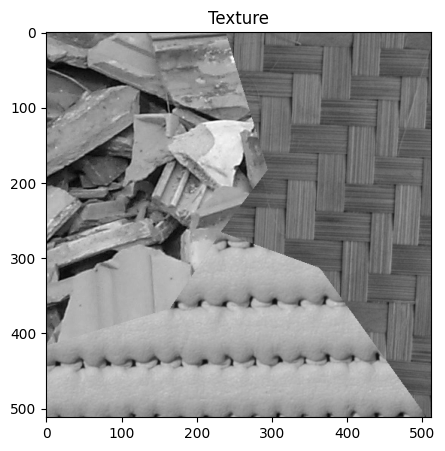

In [2]:
img = io.imread(TM_PATH)
img = img.astype(np.uint8)

plt.figure(figsize= (5, 5))
plt.title('Texture')
plt.imshow(img, cmap="gray")

C:\Users\rposa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


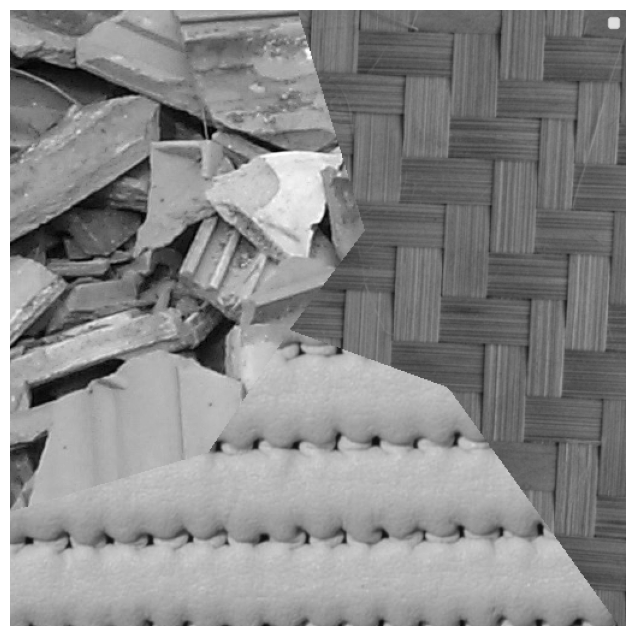

In [3]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def apply_gabor_filters(image, num_orientations, num_scales):
    filters = []
    for theta in np.linspace(0, np.pi, num_orientations):
        for sigma in (1, 2):
            kernel = cv2.getGaborKernel((5, 5), sigma, theta, 1, 0.5, 0, ktype=cv2.CV_32F)
            filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            filters.append(filtered_image)
    return filters

def reshape_for_clustering(filtered_images):
    num_pixels = filtered_images[0].shape[0] * filtered_images[0].shape[1]
    num_features = len(filtered_images)
    feature_matrix = np.zeros((num_pixels, num_features))

    for i in range(num_features):
        feature_matrix[:, i] = filtered_images[i].ravel()

    return feature_matrix

def segment_textures(image, num_clusters):
    filtered_images = apply_gabor_filters(image, num_orientations=8, num_scales=2)
    feature_matrix = reshape_for_clustering(filtered_images)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(feature_matrix)
    labels = kmeans.labels_.reshape(image.shape)

    return labels

def display_segmented_image(image, labels):
    unique_labels = np.unique(labels)
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))

    segmented_image = np.zeros_like(image, dtype=np.uint8)

    for label in unique_labels:
        segmented_region = np.zeros_like(image)
        segmented_region[labels == label] = image[labels == label]

        segmented_image += segmented_region

    plt.figure(figsize=(8, 8))
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')

    legend_labels = [f'Region {label}' for label in unique_labels]
    plt.legend(legend_labels, loc='upper right')
    plt.show()

if __name__ == '__main__':
    num_clusters = 3  # Adjust the number of clusters based on your needs
    labels = segment_textures(img, num_clusters)
    display_segmented_image(img, labels)

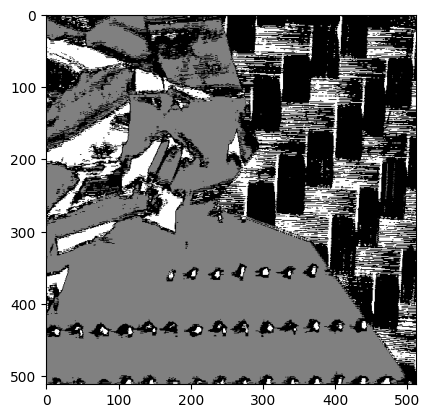

In [4]:
plt.imshow(labels, cmap='gray')

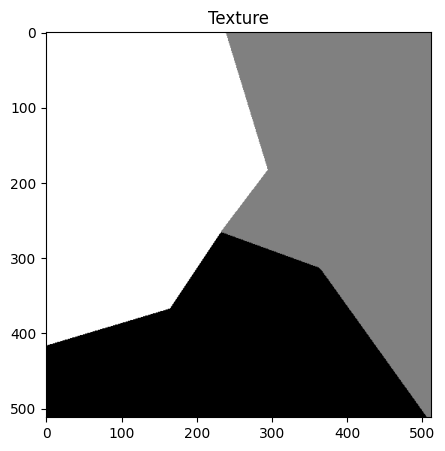

In [5]:
img_gt = io.imread(GT_PATH)
img_gt = img_gt.astype(np.uint8)

plt.figure(figsize= (5, 5))
plt.title('Texture')
plt.imshow(img_gt, cmap="gray")

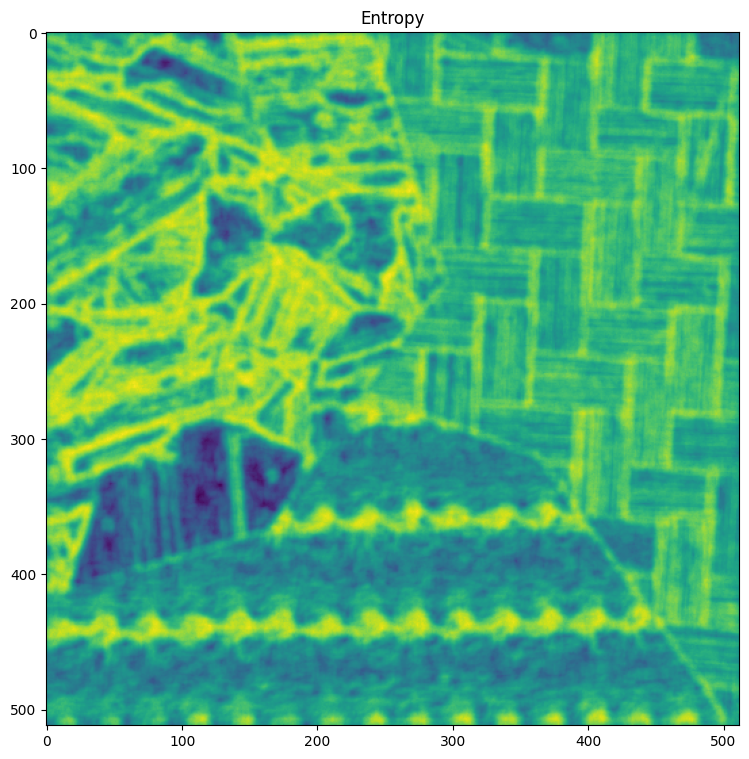

In [6]:
plt.figure(figsize= (9, 9))
plt.title('Entropy')
im_entropy = entropy(img, morphology.disk(5))
plt.imshow(im_entropy)

In [7]:
# Define the parameters for texture analysis
distances = [1]
angles = [0]
properties = ['contrast', 'correlation', 'energy', 'homogeneity']
window_size = 9

# Initialize matrices to store texture properties
im_contrast = np.zeros_like(im_entropy)
im_correlation = np.zeros_like(im_entropy)
im_energy = np.zeros_like(im_entropy)
im_homogeneity = np.zeros_like(im_entropy)

# Iterate through image slices to calculate texture properties
for i in tqdm(range(0, im_entropy.shape[0] - window_size)):
    for j in range(0, im_entropy.shape[1] - window_size):

        # Extract a window from the grayscale image
        window = img[i:i + window_size, j:j + window_size]

        # Calculate the gray-level co-occurrence matrix (GLCM) for the window
        glcm = graycomatrix(window,
                            distances=distances,
                            angles=angles,
                            symmetric=True,
                            normed=True)

        # Calculate and store texture properties in the corresponding matrices
        feats = np.hstack([graycoprops(glcm, prop).ravel() for prop in properties])
        im_contrast[i, j] = feats[0]
        im_correlation[i, j] = feats[1]
        im_energy[i, j] = feats[2]
        im_homogeneity[i, j] = feats[3]

  0%|          | 0/503 [00:00<?, ?it/s]

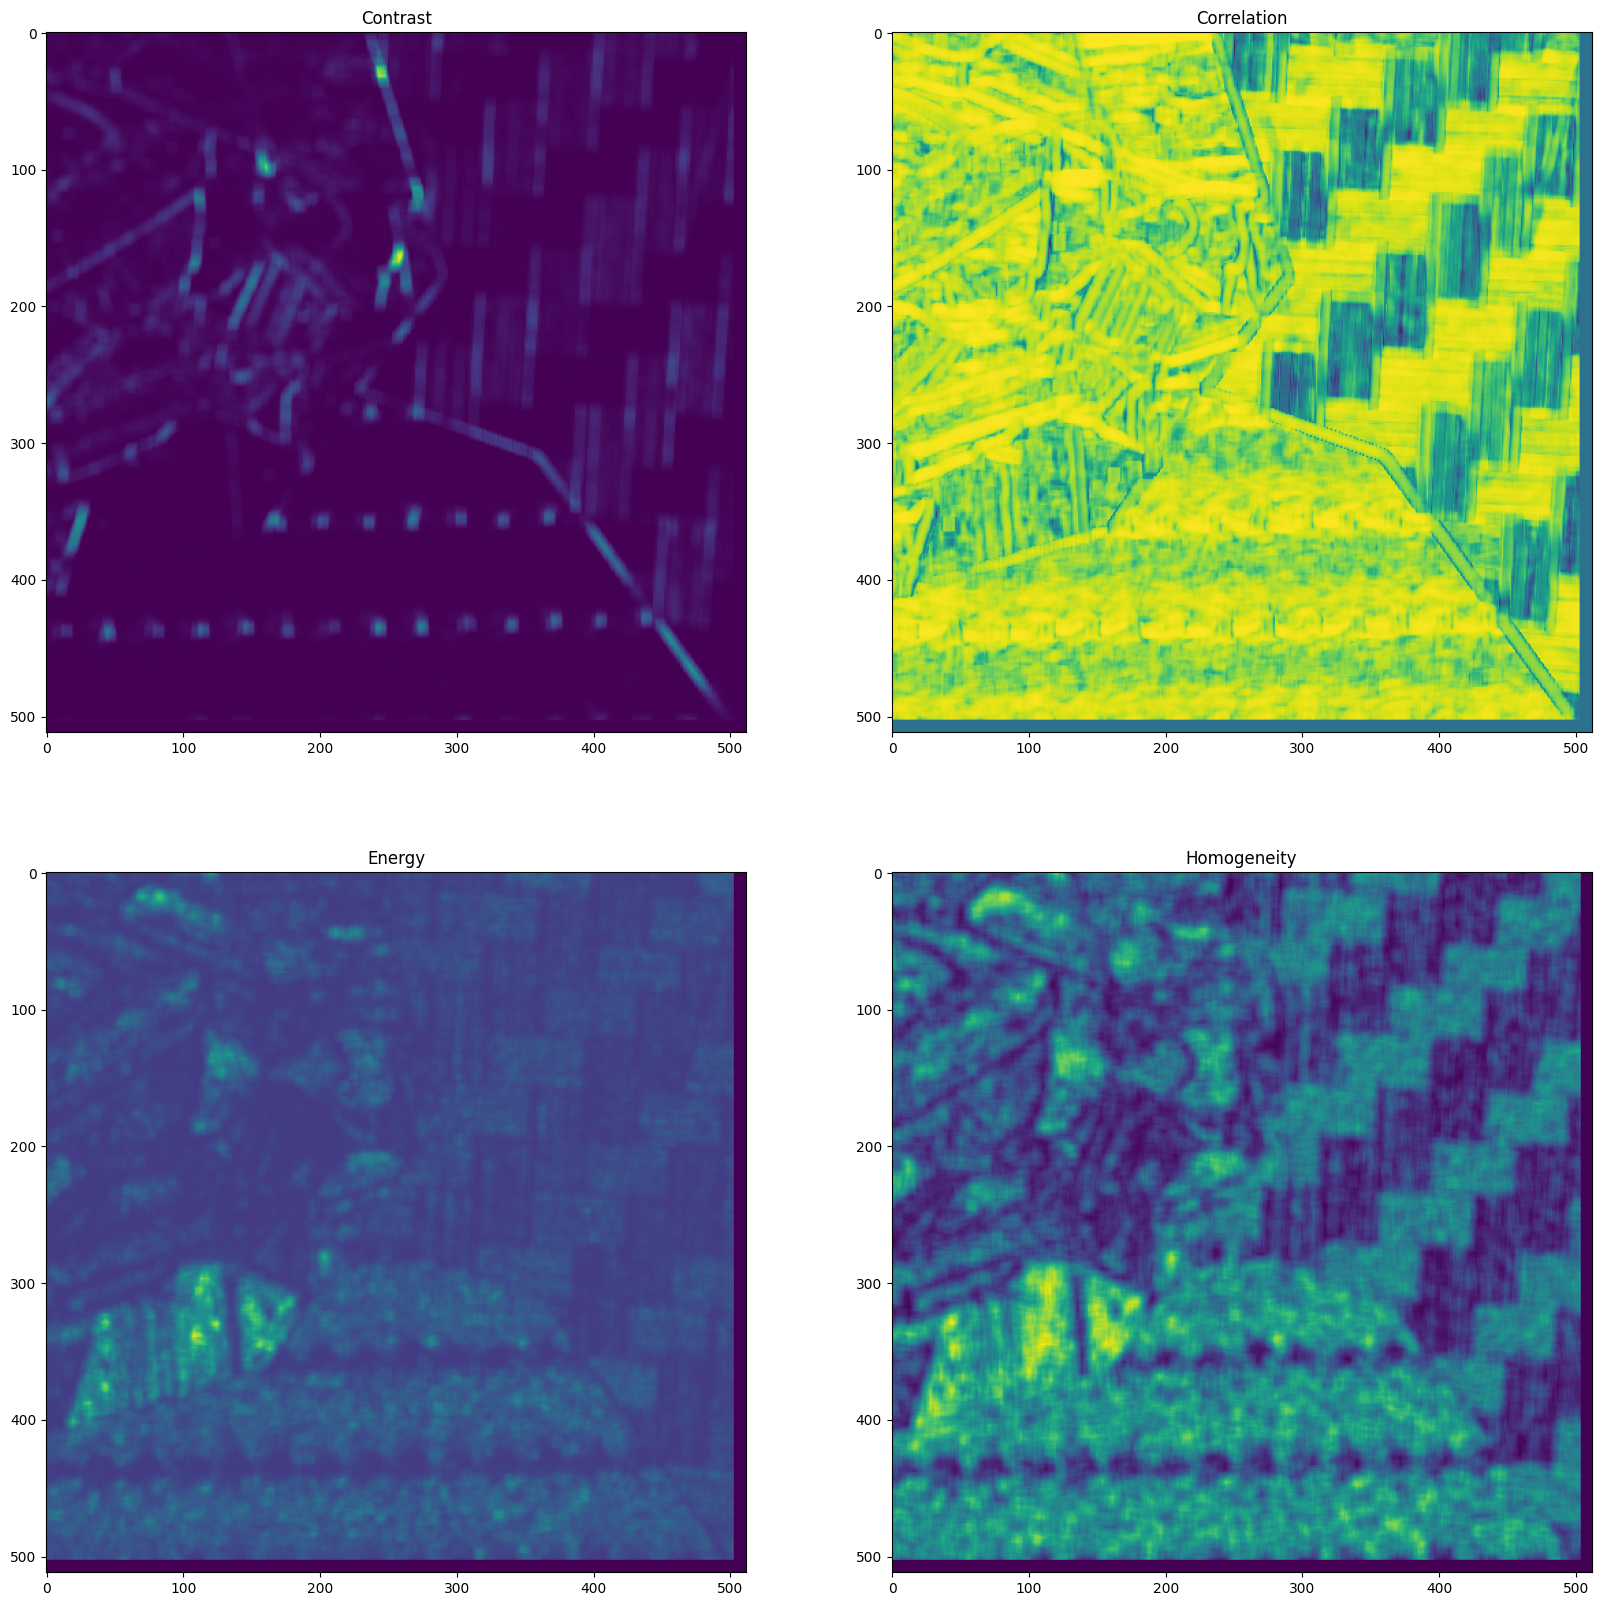

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Contrast')
plt.imshow(im_contrast)

plt.subplot(222)
plt.title('Correlation')
plt.imshow(im_correlation)

plt.subplot(223)
plt.title('Energy')
plt.imshow(im_energy)

plt.subplot(224)
plt.title('Homogeneity')
plt.imshow(im_homogeneity)

[[176 173 168 153 139 134 156 166 173 174]
 [170 166 155 138 130 131 148 155 161 170]
 [160 160 151 140 139 149 148 150 156 167]
 [156 162 158 153 152 157 150 155 161 171]
 [145 153 160 162 159 160 156 159 161 170]
 [136 144 160 164 161 156 155 152 154 167]
 [137 141 155 154 151 149 151 150 153 164]
 [141 148 155 152 151 153 153 160 165 168]
 [134 155 164 160 156 156 157 161 165 166]
 [113 150 164 161 155 155 154 149 148 154]] 
 [[169 162 159 156 151 154 165 158 162 168]
 [172 167 167 165 162 164 171 168 171 175]
 [176 175 173 172 169 173 175 178 174 170]
 [183 184 177 175 173 179 176 174 169 163]
 [182 184 180 179 176 181 182 182 176 167]
 [182 186 178 174 172 175 182 188 182 174]
 [179 185 178 170 170 171 177 184 178 169]
 [172 179 180 177 169 167 168 172 169 166]
 [170 179 182 179 172 168 163 164 163 163]
 [163 175 180 176 174 167 158 157 158 158]]


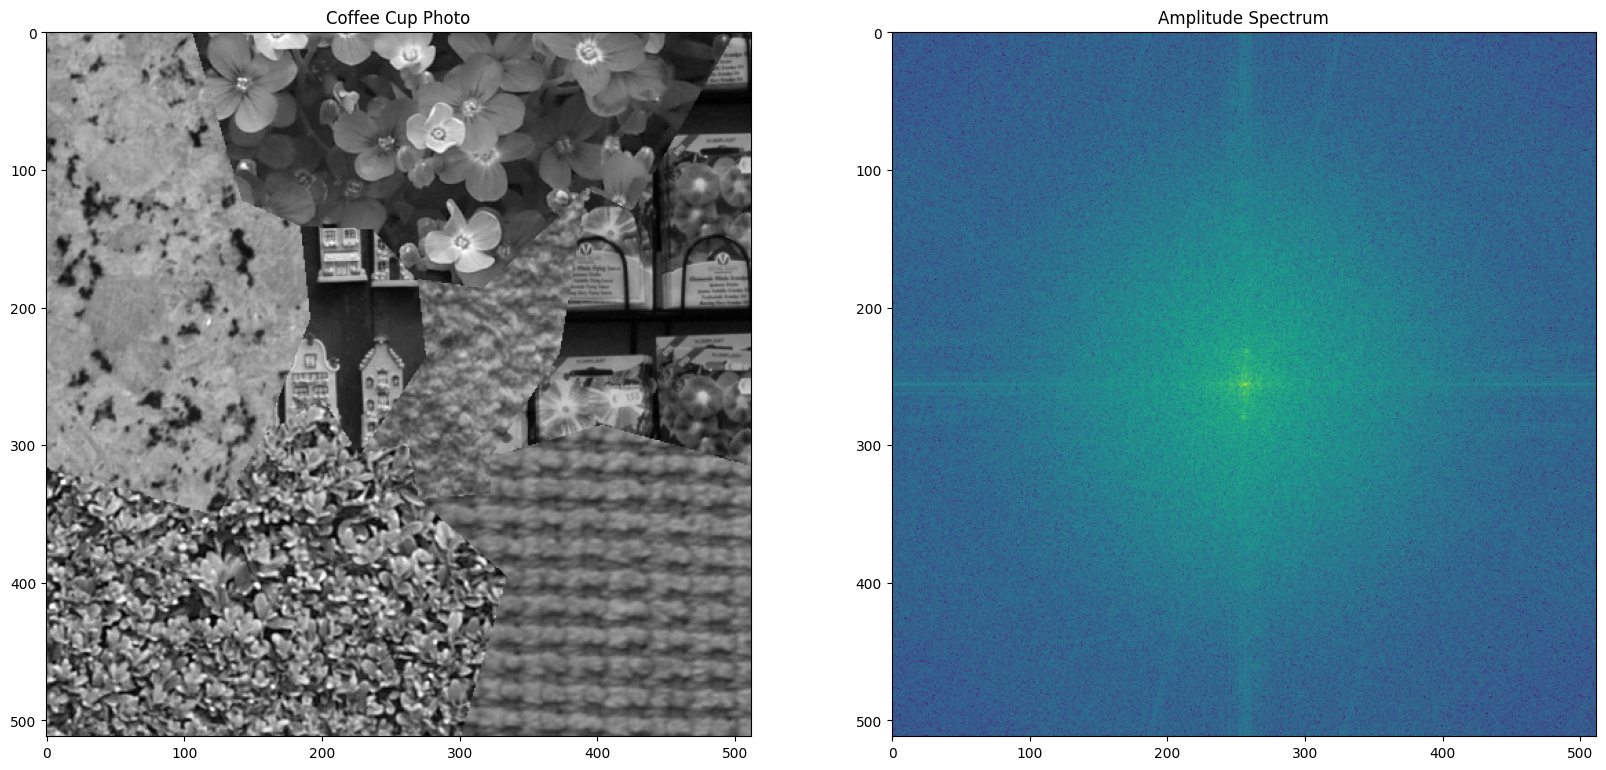

In [51]:
import numpy as np
from scipy import fft
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from skimage import data, color, transform
from skimage.color import rgb2gray
from scipy.ndimage import binary_dilation

# Load a color image of a coffee cup and convert it to grayscale
img = io.imread('textury_train/tm5_1_1.png').astype(np.uint8)

# Create a figure with two subplots for visualization
plt.figure(figsize=(20, 15))

# Subplot 1: Display the original grayscale image
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img, cmap='gray')

# Subplot 2: Display the amplitude spectrum of the image
img_fft = fft.fft2(img)  # Perform a 2D Fourier Transform on the grayscale image
zero_center_img_fft = fft.fftshift(img_fft)  # Shift the zero frequency component to the center
plt.subplot(122)
plt.title('Segmented Image')

# Plot the logarithm of the absolute values of the zero-centered FFT
plt.imshow(np.log(1 + np.abs(zero_center_img_fft)))

# np.average(zero_center_img_fft)
print(img[0:10, 0:10], '\n', img[0:10, 10:20])

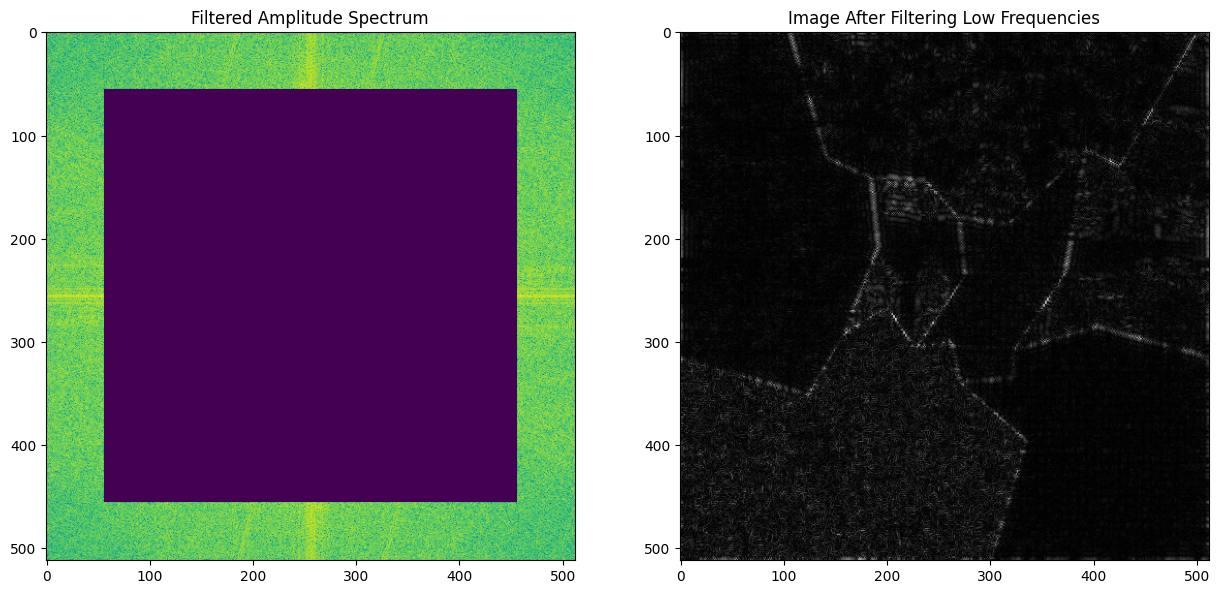

In [23]:
# Define the number of pixels to suppress in the filtered spectrum
pixels = 200

# Create a figure for visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Display the filtered amplitude spectrum
plt.subplot(121)
plt.title('Filtered Amplitude Spectrum')

# Perform a 2D Fourier Transform on the grayscale image
img_fft = fft.fft2(img)
zero_center_img_fft = fft.fftshift(img_fft)
img_size = img.shape
filt_spect = zero_center_img_fft

# Set a rectangular region in the frequency domain to zero (high-pass filter)
filt_spect[img_size[0] // 2 - pixels:img_size[0] // 2 + pixels, img_size[1] // 2 - pixels:img_size[1] // 2 + pixels] = 0 + 0j

# Plot the logarithm of the absolute values of the filtered spectrum
plt.imshow(np.log(1 + np.abs(filt_spect)))

# Subplot 2: Display the image after filtering out low frequencies
plt.subplot(122)
plt.title('Image After Filtering Low Frequencies')

# Perform an inverse 2D Fourier Transform to reconstruct the filtered image
inverse_img = fft.ifft2(filt_spect)

# Plot the absolute values of the inverse image using a grayscale colormap
plt.imshow(np.abs(inverse_img), cmap='gray')

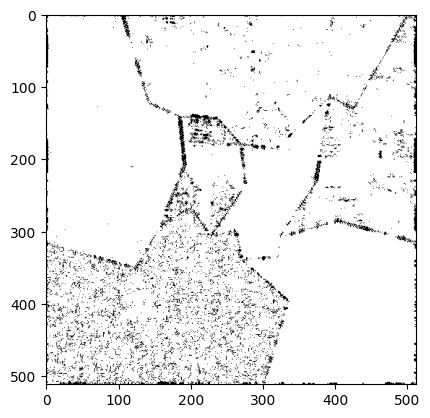

In [24]:
edge_img = np.abs(inverse_img) / np.max(np.abs(inverse_img))
threshold = 0.15

edges = edge_img < threshold

plt.imshow(edges, cmap='gray')

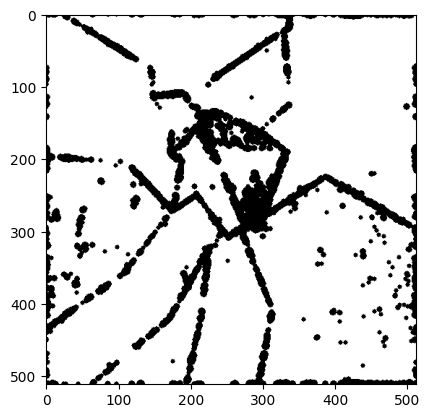

In [181]:
import cv2
import numpy as np
import skimage
from skimage.morphology import erosion
from skimage import img_as_ubyte

binary_image = edges.astype(np.uint8) * 255

selem = skimage.morphology.disk(3)

eroded_image = erosion(binary_image, selem, )

eroded_image = img_as_ubyte(eroded_image)

plt.imshow(eroded_image, cmap='gray')

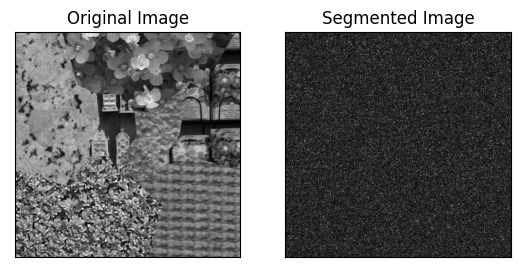

array([[1.35242799e-02, 1.71673403e-03, 6.38652233e-03, ...,
        1.95930155e-02, 1.50316164e-02, 6.69241525e-03],
       [2.45271242e-02, 8.78737481e-03, 7.34862443e-04, ...,
        6.20269103e-03, 1.19065217e-05, 1.98777141e-02],
       [7.02967357e-04, 1.17740832e-03, 9.48936095e-03, ...,
        1.42925639e-02, 6.45031954e-03, 1.23823449e-02],
       ...,
       [6.57807266e-03, 9.37073571e-03, 4.63162189e-03, ...,
        5.14547625e-03, 2.36569721e-03, 1.04768826e-03],
       [7.04065774e-03, 3.78291218e-03, 4.10491153e-03, ...,
        1.18850005e-02, 1.55213844e-03, 2.36346478e-03],
       [2.13296594e-03, 1.66939273e-02, 1.18450115e-02, ...,
        6.69763520e-03, 9.35304016e-03, 2.18271996e-02]])

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an example image
image = io.imread('textury_train/tm5_1_1.png').astype(np.uint8)

# Apply Fourier Transform
f_transform = np.fft.fft2(image)
f_shift = np.fft.fftshift(f_transform)

# Create a magnitude spectrum
magnitude_spectrum = 20 * np.log(np.abs(f_shift))

# Threshold the magnitude spectrum to identify textures
threshold = 100
texture_mask = magnitude_spectrum > threshold

# Apply inverse Fourier Transform to get the segmented image
f_shift[texture_mask] = 0
f_transform_inverse = np.fft.ifft2(np.fft.ifftshift(f_shift))
segmented_image = np.abs(f_transform_inverse)

# Display the original image and segmented result
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [29]:
# image = io.imread('textury_train/tm5_1_1.png').astype(np.uint8)

In [44]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

# Function to compute Local Binary Pattern (LBP) histogram for each pixel
def compute_lbp(image):
    lbp = cv2.texture.LBP_create()
    return lbp.compute(image)

# Function to segment the image using KMeans clustering
def segment_image(image, num_clusters):
    # Reshape the image into a 2D array of pixels
    pixels = image.reshape((-1, 1))

    # Use KMeans clustering to segment pixels based on texture
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(pixels)

    # Reshape the labels back to the original image shape
    segmented_image = kmeans.labels_.reshape(image.shape)

    return segmented_image

# Read the input image
input_image = cv2.imread('textury_train/tm1_1_1.png', cv2.IMREAD_GRAYSCALE)

# Compute LBP features for the input image
lbp_features = compute_lbp(input_image)

# Specify the number of clusters (you may need to tune this parameter)
num_clusters = 3

# Segment the image using KMeans clustering
segmented_image = segment_image(lbp_features, num_clusters)

# Display the original and segmented images
cv2.imshow('Original Image', input_image)
cv2.imshow('Segmented Image', (segmented_image * (255 / num_clusters)).astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()


AttributeError: module 'cv2' has no attribute 'texture'

In [ ]:
import cv2
from scipy.signal import correlate2d

def calculate_fft(img):
    # Calculate FFT of the image
    f_transform = np.fft.fft2(img)
    # Shift the zero frequency component to the center
    f_transform_shifted = np.fft.fftshift(f_transform)
    # Calculate the magnitude spectrum
    magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

    return magnitude_spectrum

def compare_fft_images(fft_img1, fft_img2):
    # Normalize the images
    fft_img1 = cv2.normalize(fft_img1, None, 0, 255, cv2.NORM_MINMAX)
    fft_img2 = cv2.normalize(fft_img2, None, 0, 255, cv2.NORM_MINMAX)

    # Calculate the cross-correlation between the two FFT images
    correlation = correlate2d(fft_img1, fft_img2, mode='same', boundary='wrap')

    # Find the maximum correlation value and its corresponding location
    max_corr_val = np.max(correlation)
    max_corr_loc = np.unravel_index(np.argmax(correlation), correlation.shape)

    return max_corr_val, max_corr_loc

In [ ]:
import cv2
from skimage import feature

def calculate_lbp(img, num_points=100, radius=100, method='uniform'):
    # Calculate the Local Binary Pattern
    lbp = feature.local_binary_pattern(img, num_points, radius, method)

    return lbp

def compare_texture(img1, img2):
    # Calculate LBP for both images
    lbp1 = calculate_lbp(img1)
    lbp2 = calculate_lbp(img2)

    # Flatten the LBP images
    flat_lbp1 = lbp1.flatten()
    flat_lbp2 = lbp2.flatten()

    # Compute the histogram intersection
    intersection = np.minimum(flat_lbp1, flat_lbp2).sum()
    union = np.maximum(flat_lbp1, flat_lbp2).sum()

    # Calculate the texture similarity
    return intersection / union

In [ ]:
def show_fft_segs(img, img_seg):
    plt.figure(figsize=(20, 15))

    plt.subplot(121)
    plt.title('Original Image')
    plt.imshow(img, cmap='gray')

    plt.subplot(122)
    plt.title('Segmented Image')
    plt.imshow(np.log(1 + np.abs(img_seg)))

In [ ]:
image = io.imread(TM_PATH).astype(np.uint8)

img_fft = fft.fftshift(fft.fft2(image))

show_fft_segs(image, img_fft)

# np.average(zero_center_img_fft)
size = 100
image1 = image[:size, 0:size]
image2 = image[:size, size*1:size*2]
image3 = image[:size, size*2:size*3]
image4 = image[:size, size*3:size*4]
image5 = image[:size, size*4:size*5]

img_fft1 = fft.fftshift(fft.fft2(image1))
img_fft2 = fft.fftshift(fft.fft2(image2))
img_fft3 = fft.fftshift(fft.fft2(image3))
img_fft4 = fft.fftshift(fft.fft2(image4))
img_fft5 = fft.fftshift(fft.fft2(image5))

print(f'{np.average(img_fft1)}\n{np.average(img_fft2)}\n'
      f'{np.average(img_fft3)}\n{np.average(img_fft4)}\n'
      f'{np.average(img_fft5)}')

show_fft_segs(image1, img_fft1)
show_fft_segs(image2, img_fft2)
show_fft_segs(image3, img_fft3)
show_fft_segs(image4, img_fft4)
show_fft_segs(image5, img_fft5)

# Calculate FFT of the images
fft_image1 = calculate_fft(image1)
fft_image2 = calculate_fft(image1)

# Compare the FFT images
max_corr_value, max_corr_location = compare_fft_images(fft_image1, fft_image2)

# Output the results
print(f"Maximum Correlation Value: {max_corr_value}")
print(f"Location of Maximum Correlation: {max_corr_location}")

# Calculate FFT of the images
fft_image1 = calculate_fft(image5)
fft_image2 = calculate_fft(image5)

# Compare the FFT images
max_corr_value, max_corr_location = compare_fft_images(fft_image1, fft_image2)

# Output the results
print(f"Maximum Correlation Value: {max_corr_value}")
print(f"Location of Maximum Correlation: {max_corr_location}")


similarity = compare_texture(image1, image2)
print(f"Texture Similarity: {similarity}")

In [ ]:
# area = 1
# sqr_size = 40
# pixel_threshold = 260
# ground_truth_outp = np.full((image.shape[0],image.shape[1]), 0)
#
# # 1st Row
# for x in range(int(image.shape[0]/sqr_size)*2, -1, -1):
#     square = dilated_image[:sqr_size, int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))]
#     if np.sum(square) < pixel_threshold:
#         ground_truth_outp[:sqr_size, int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = area
#     elif np.any(ground_truth_outp == area):
#         area += 1
#
# # 1st Column
# for y in range(2, int(image.shape[1]/sqr_size)*2+1):
#     square = dilated_image[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), :sqr_size]
#     if np.sum(square) < pixel_threshold:
#         ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), :sqr_size] = area
#     elif np.any(ground_truth_outp == area):
#         area += 1
#
# # rest of the rows, row by row
# for y in range(1, int(image.shape[1]/sqr_size)*2):
#     for x in range(1, int(image.shape[1]/sqr_size)*2):
#         square = dilated_image[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
#                  int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))]
#         if np.sum(square) < pixel_threshold:
#             # corner values
#             upF = ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1][int(sqr_size*(x/2))]
#             upL = ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1][int(sqr_size*(x/2))+sqr_size-1]
#             leftF = ground_truth_outp[int(sqr_size*(y/2))][int(sqr_size*(x/2))+int(sqr_size/2)-1]
#             leftL = ground_truth_outp[int(sqr_size*(y/2))+sqr_size-1][int(sqr_size*(x/2))+int(sqr_size/2)-1]
#
#             # copy up if [0] == [-1] of the square above & if not 0 & if left = 0
#             if upF == upL and (upF != 0 or upL != 0) and (upL == leftL or leftL == 0):
#                 ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
#                 int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = upF
#
#             # copy left if [0] == [-1] of the square of the left & if not 0 & if up = 0
#             elif leftF == leftL and (leftF != 0 or leftL != 0) and (upL == leftL or upL == 0):
#                 ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
#                 int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = leftF
#
#             elif upL == 0 and leftL == 0:
#                 new_x = x
#                 while ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1][int(sqr_size*(new_x/2))+sqr_size-1] == 0 \
#                         and (np.sum(dilated_image[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)),
#                                     int(sqr_size*(new_x/2)):int(((sqr_size*(new_x+2))/2))]) < pixel_threshold):
#                     new_x += 1
#
#                 if ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1][int(sqr_size*(new_x/2))+sqr_size-1] == 0 or \
#                         (np.sum(dilated_image[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)),
#                                 int(sqr_size*(new_x/2)):int(((sqr_size*(new_x+2))/2))]) < pixel_threshold):
#                     ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
#                     int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = area
#                 else:
#                     ground_truth_outp[int(sqr_size*(y/2)):int(((sqr_size*(y+2))/2)), \
#                     int(sqr_size*(x/2)):int(((sqr_size*(x+2))/2))] = ground_truth_outp[int(sqr_size*(y/2))+int(sqr_size/2)-1] \
#                         [int(sqr_size*(new_x/2))+sqr_size-1]
#
#         elif np.any(ground_truth_outp == area):
#             area += 1
#
# compare_img(image, ground_truth_outp)